## Data 608 - Homework 4
### Liam Byrne

**Background:** Enterococcus is a fecal indicating bacteria that lives in the intestines of humans and other warm-blooded animals. Enterococcus (“ Entero”) counts are useful as a water quality indicator due to their abundance in human sewage, correlation with many human pathogens and low abundance in sewage free environments. The United States Environmental Protection Agency (EPA) reports Entero counts as colonies (or cells) per 100 ml of water.

Riverkeeper has based its assessment of acceptable water quality on the 2012 Federal Recreational Water Quality Criteria from the US EPA. Unacceptable water is based on an illness rate of 32 per 1000 swimmers. The federal standard for unacceptable water quality is a single sample value of greater than 110 Enterococcus/100 mL, or five or more samples with a geometric mean (a weighted average) greater than 30 Enterococcus/100 mL.

#### Explore and Clean Data


In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import qgrid as qg
qg.nbinstall(overwrite = True)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.mstats import gmean

In [2]:
river_entero = pd.read_csv(
    "https://raw.githubusercontent.com/charleyferrari/CUNY_DATA608/master/lecture4/Data/riverkeeper_data_2013.csv")

Giving a glance at the data, we notice that there are a `<` and `>` symbols in the `EnteroCount` fields. This was probably used when values were outside a measuring capacity. Due to this, as is seen below, the data type is generic; this will need to be addressed.

In [3]:
river_entero[20:30]

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
20,Hudson above Mohawk River,8/21/2010,25,0.2,35
21,Hudson above Mohawk River,7/19/2010,31,0.7,35
22,Hudson above Mohawk River,5/22/2008,12,0.2,35
23,Hudson above Mohawk River,5/25/2010,<1,0.0,35
24,Hudson above Mohawk River,10/23/2009,4,0.0,35
25,Hudson above Mohawk River,9/17/2009,28,0.0,35
26,Hudson above Mohawk River,8/24/2009,276,2.8,35
27,Hudson above Mohawk River,7/31/2009,>2420,1.9,35
28,Hudson above Mohawk River,5/15/2009,6,0.5,35
29,Hudson above Mohawk River,10/23/2008,<1,0.3,35


In addition, the data type for `Date` is wrong (it is stored as a string). The following code, utilizing casting and some simple regex, remedies these issues. Using `qgrid`, the enireity of the cleaned data set is viewable in a sortable\filterable interface below.

In [4]:
river_entero.dtypes

Site                 object
Date                 object
EnteroCount          object
FourDayRainTotal    float64
SampleCount           int64
dtype: object

In [5]:
river_entero.Date = pd.to_datetime(
    river_entero.Date,
    errors = "coerce")

river_entero.EnteroCount = pd.to_numeric(
    river_entero.EnteroCount.replace("\D+","", regex = True),
    errors = "coerce")

river_entero = river_entero.dropna(axis=0)

# Need to drop EnteroCount >0 to make geometric mean fair
river_entero = river_entero[river_entero.EnteroCount>0]


qg.show_grid(river_entero)

### Question 1
**Create lists & graphs of the best and worst places to swim in the dataset.**

Pandas' `groupby` tool makes quick bussiness of this. The table, with the lowest `SwimRank` denoting the lowest average Entero Count by `Site`, is available below. The rank of the best places to swim were based off of the geometric mean of the Entero Counts.

In [6]:
river_avg = pd.DataFrame(river_entero.EnteroCount.groupby(river_entero.Site).aggregate({"GeomMeanEntero":gmean}))
river_avg = river_avg.sort_values(by = "GeomMeanEntero", ascending = True)
river_avg['SwimRank'] = river_avg.GeomMeanEntero.rank()
qg.show_grid(river_avg)

The graph below shows the respective `Site`s' average Entero count and is sorted, bottom - up, by the increase in Entero geometric means. The `Site`s that are over the EPA limit of 30 Enterococcus/100 mL are colored red and are unsafe, those under the limit are colored green.

In [7]:
mask1 = river_avg.GeomMeanEntero <= 30
mask2 = river_avg.GeomMeanEntero > 30

dat = [
    go.Bar(
        y = river_avg.index[mask1],
        x = river_avg.GeomMeanEntero[mask1],
        marker = dict(
            color = "green"
            ),
        name = "Safe Swimming Water",
        orientation = 'h'),
    go.Bar(
        y = river_avg.index[mask2],
        x = river_avg.GeomMeanEntero[mask2],
        marker = dict(
            color = "red"
            ),
        name = "Water over EPA limits",
        orientation = 'h')
    ]

lay = go.Layout(
   height = '1400',
    margin = go.Margin(l=300),
    title = "Geometric Mean of Entero Counts by Site",
    xaxis = {"title" : "Entero Count"}
)

fig = go.Figure(data = dat, layout = lay)

py.iplot(fig)

### Question 2
**The testing of water quality can be sporadic. Which sites have been tested most regularly? Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.**

In order to find out how sporadic the tests were carried out, the average difference between testing date were computed. The sites are ranked by how frequently they were tested, in ascending order. The table below shows these rankings along with the number of tests thatthe EPA would consider a non-acceptable level of Enero.

In [8]:
# Find the average timedelta between tests for sites.
def date_delta(x) :
    x = x.sort_values()
    delta = []
    tmp = []
    
    #put series into list because off-set is indexing difficult with pd.core.series.series
    for i in x:
        tmp.append(i)        
        
    for i in xrange(1,len(tmp)) :
        delta.append((tmp[i]-tmp[i-1]))
     
    return(np.mean(delta))

test_diff = pd.DataFrame(river_entero.groupby(['Site']).Date.aggregate({"DaysBtwnTest":date_delta}))
test_diff = test_diff.sort_values(by = "DaysBtwnTest", ascending = True)
test_diff['TestRank'] = test_diff.rank()
test_diff.DaysBtwnTest = test_diff.DaysBtwnTest.dt.days #Convert timedelta to days

# Count times each site exceeds Enterno regulaiton
exceed_cnt = pd.DataFrame(
    river_entero.groupby(
        river_entero.Site).aggregate(
        lambda x: sum(x.EnteroCount > 110)).EnteroCount)

test_diff["ExceededRegulation"] = exceed_cnt.EnteroCount[test_diff.index]
qg.show_grid(test_diff)

The top 3 tested sites (those tested most frequently) and the bottom 3 (had the most, on average, large gaps between tests) with their respective ranks are:

* 1 - Upper Sparkill Creek
* 2 - Piermont Pier
* 3 - Nyack Launch Ramp
* 73 - Stony Point mid-channel
* 74 - Gowanus Canal
* 75 - Tarrytown Marina

They are plotted below. The red scatter indicates that the specific test exceeded EPA Entero levels. It was thought that being over EPA limits would cause more frequent tests in an attempt to get the geometric mean down below the 30 Entero count. From the table above and this graph below, this idea does not hold water.

In [9]:
# Get data for top three and bottom 3 ranked testing sites
test_days = river_entero[
    river_entero.Site.isin(
        list(
            test_diff[
                (test_diff.TestRank <= 3) | (test_diff.TestRank > test_diff.TestRank.max() - 3)
            ].sort_values("TestRank").index)
    )
]

mask1 = test_days[test_days.EnteroCount <= 110]
mask2 = test_days[test_days.EnteroCount > 110]

dat = [
    go.Scatter(
        x = mask1.Date,
        y = mask1.Site,
        mode = "markers",
        name = "Under EPA limit",
        marker = dict(
            color = "green"
            )
    ),
    go.Scatter(
        x = mask2.Date,
        y = mask2.Site,
        mode = "markers",
        name = "Over EPA limit",
        marker = dict(
            color = "red"
            )
    )
]

lay = go.Layout(
    margin = go.Margin(l=150),
    title = "Testing Days of Sites",
    xaxis = {"title" : "Date"},
    yaxis = {"type" : "category"}
)

fig = go.Figure(data = dat, layout = lay)

py.iplot(fig)

### Quesiton 3

**Is there a relationship between the amount of rain and water quality? Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them.**

First we will look at the correlation for the variables.

In [10]:
river_entero.corr()

,EnteroCount,FourDayRainTotal,SampleCount
EnteroCount,1.000000,0.144805,0.077889
FourDayRainTotal,0.144805,1.000000,0.001875
SampleCount,0.077889,0.001875,1.000000


From the correlations above it does not appear that there is a correlaiton between `FourDayRainTotal` and `EnteroCount`. In order to take a closer look at this correlaiton, we will group the data by `FourDayRainTotal` and average Entero counts to get a clearer view of the relaitonship. The findings are plotted below using Seaborn's simple ordinary least squares regression tool. Outliers were removed prior to the fitting process.

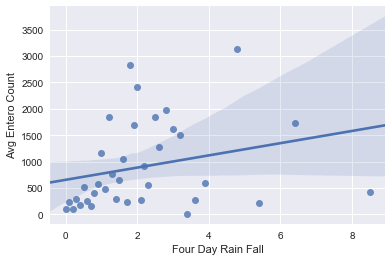

In [11]:
rain = pd.DataFrame(
    river_entero.groupby(
        ["FourDayRainTotal"]).EnteroCount.agg(
            {"AvgEnteroCount" : np.mean}))

# Remove values > 3 stds from mean
rain = rain[np.abs(
        rain.AvgEnteroCount - rain.AvgEnteroCount.mean()) <=
            3*rain.AvgEnteroCount.std()]

ax = sns.regplot(rain.index.values,rain.AvgEnteroCount.values)
ax.set_xlabel("Four Day Rain Fall")
ax.set_ylabel("Avg Entero Count")

The regression line is nearly flat and there appears to be a weak correlaiton between rainfall and Entero levels. The $R^2$ is 0.067, which means the variability of the Entero Count is not well described by Rain Fall. A log-scale transform was attempted, but it also did not render an appropriate fit.

Even though it is not appropriate to use rain fall as predictor for Entero counts, we can still visualize the two. The plot below shows Entero counts by site for the 10 largest violators of exceeding EPA Entero count levels. The size of the marker represents the rainfall; the larger the marker, the larger the rainfall. A log-scale is used for Entero count on the x-axis due to the heavily right-skewed data. It is not a good way to estimate the effects of rain on Entero counts, but it is helpful in seeing that there is not correlaiton.

In [12]:
#Filter our all but the 10 worst Sites
river = river_entero[
    river_entero.Site.isin(
        river_avg[river_avg.SwimRank > max(river_avg.SwimRank)-10].index
    )
]

dat = [
    go.Scatter(
        x = river.EnteroCount,
        y = river.Site,
        mode = "markers",
        marker = dict(
            size = river.FourDayRainTotal*5
            )
    )
]

lay = go.Layout(
    margin = go.Margin(l=200),
    title = "Rain Fall and the 10 Largest Violators of Exceeding EPA Entero Levels",
    xaxis = dict (
        {"title" : "Entero Count"},
        type='log',
        autorange=True
    )
)

fig = go.Figure(data = dat, layout = lay)

py.iplot(fig)